In [1]:
import re
import nltk
import string
import spacy

import numpy as np
import pandas as pd
from spacy import displacy

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from keras.utils import pad_sequences
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from keras.optimizers import SGD

from keras.metrics import Precision, Recall
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, LSTM, Dropout, Embedding, Bidirectional, BatchNormalization, Attention, Concatenate, Input
from keras.models import Sequential
from keras import Model
from keras.layers import Layer
from keras.utils import plot_model
import keras.backend as K

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
import os

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kusha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kusha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
train_df = pd.read_csv('twitter_training.csv', names=['_id', 'game', 'sentiment', 'text'])
validation_df = pd.read_csv('twitter_validation.csv', names=['_id', 'game', 'sentiment', 'text'])

In [4]:
train_df.head()

,_id,game,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
original_df = train_df.copy()

<AxesSubplot: title={'center': 'Tweets for each sentiment in dataset'}>

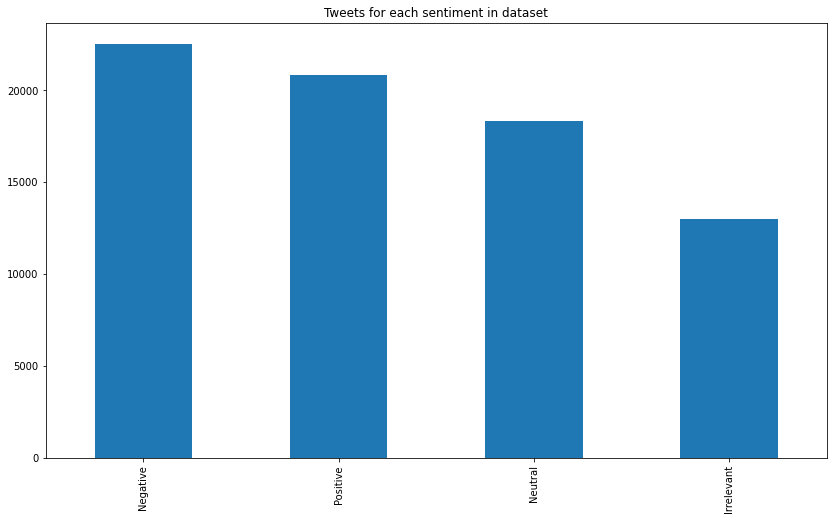

In [6]:
train_df['sentiment'].value_counts().plot(kind='bar', figsize=(14, 8), title='Tweets for each sentiment in dataset')

### Data Preprocessing

In [7]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text) # Remove special char
    text = re.sub(r'<.*?>', '', text) # Remove html tags
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    text = ' '.join(tokens)
    return text

In [8]:
train_df.text = train_df.text.astype('str')
validation_df.text = validation_df.text.astype('str')
train_df.text = train_df.text.apply(normalize_text)
validation_df.text = validation_df.text.apply(normalize_text)

In [9]:
train_df.head()

,_id,game,sentiment,text
0,2401,Borderlands,Positive,im get borderland murder
1,2401,Borderlands,Positive,come border kill
2,2401,Borderlands,Positive,im get borderland kill
3,2401,Borderlands,Positive,im come borderland murder
4,2401,Borderlands,Positive,im get borderland murder


In [10]:
train_df = train_df[(train_df.sentiment == 'Positive')| (train_df.sentiment == 'Negative')]
validation_df = validation_df[(validation_df.sentiment == 'Positive')| (validation_df.sentiment == 'Negative')]

In [11]:
sample_original = original_df['text'][20]
sample_original

'that was the first borderlands session in a long time where i actually had a really satisfying combat experience. i got some really good kills'

In [12]:
train_df.sentiment.replace('Positive', 1, inplace=True)
train_df.sentiment.replace('Negative', 0, inplace=True)
validation_df.sentiment.replace('Positive', 1, inplace=True)
validation_df.sentiment.replace('Negative', 0, inplace=True)

In [13]:
train_df.head(10)

,_id,game,sentiment,text
0,2401,Borderlands,1,im get borderland murder
1,2401,Borderlands,1,come border kill
2,2401,Borderlands,1,im get borderland kill
3,2401,Borderlands,1,im come borderland murder
4,2401,Borderlands,1,im get borderland murder
5,2401,Borderlands,1,im get borderland murder
6,2402,Borderlands,1,spent hour make someth fun dont know huge bord...
7,2402,Borderlands,1,spent coupl hour someth fun dont know im huge ...
8,2402,Borderlands,1,spent hour someth fun dont know im huge border...
9,2402,Borderlands,1,spent hour make someth fun dont know huge rhan...


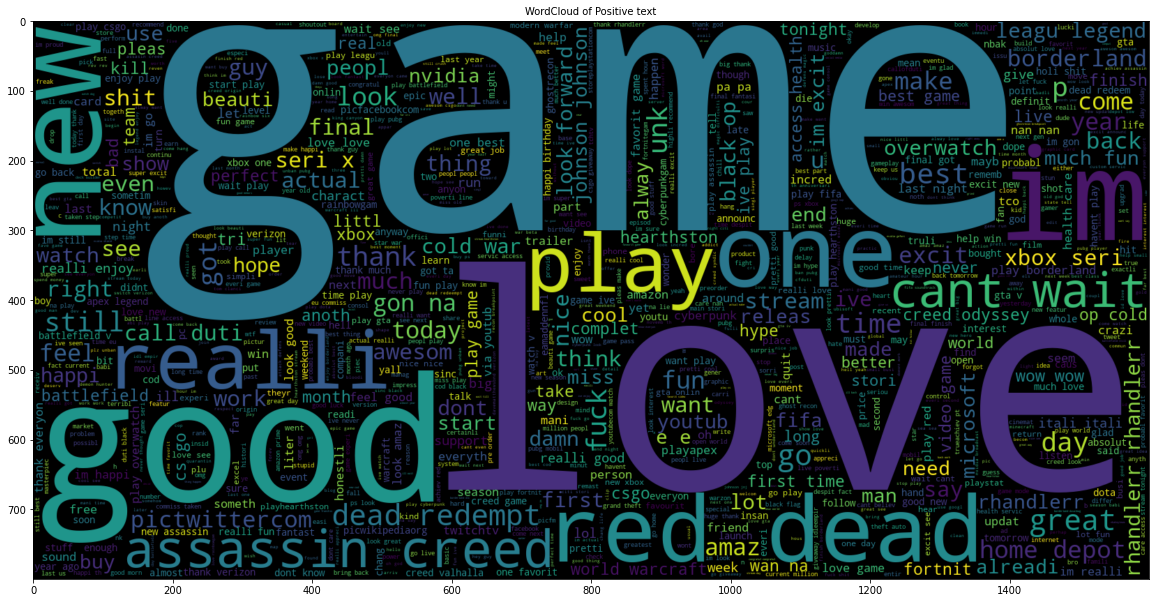

In [14]:
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=1000, width=1600, height=800).generate(' '.join(train_df[train_df.sentiment == 1]['text']))
plt.title('WordCloud of Positive text', size=10)
plt.imshow(wc, interpolation='bilinear')

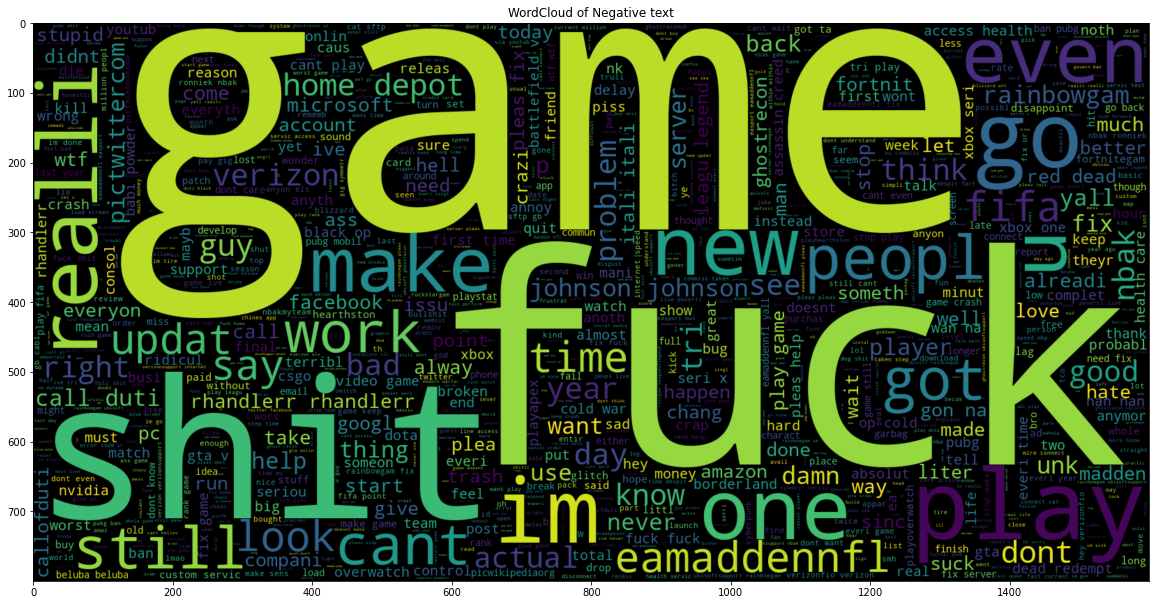

In [15]:
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=1000, width=1600, height=800).generate(' '.join(train_df[train_df.sentiment == 0]['text']))
plt.title('WordCloud of Negative text')
plt.imshow(wc, interpolation='bilinear')

In [16]:
def fit_transform(tokenizer, text):
    return pad_sequences(tokenizer.texts_to_sequences(text), padding='post', maxlen=max_len)

max_len, max_features = 628, 1000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(train_df.text)
X = fit_transform(tokenizer, train_df.text)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, train_df.sentiment, random_state=420, stratify=train_df.sentiment, test_size=0.2)

In [18]:
print('Train data Shape: ',X_train.shape)
print('Test data shape: ',X_test.shape)

Train data Shape:  (34699, 628)
Test data shape:  (8675, 628)


In [19]:
class attention(Layer):
    def __init__(self, **kwargs):
        super(attention, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        self.B = self.add_weight(name='attention_bias', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)
    
    def call(self, X):
        e = K.tanh(K.dot(X, self.W) + self.B)
        e = K.squeeze(e, axis=-1)
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        context = X * alpha
        context = K.sum(context, axis=1)
        return context

In [20]:
def lstm_model(input_len, max_features=1000, embed_size=128):
    input_layer = Input(shape=(input_len, ), dtype='int32')
    embedded_layer = Embedding(max_features, embed_size)(input_layer)
    lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(embedded_layer)
    attention_layer = attention()(lstm_layer)
    output_layer = Dense(1, activation='sigmoid')(attention_layer)

    model = Model(input_layer, output_layer)
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=1e-3), 
                  metrics=['accuracy', Precision(), Recall()])
    return model

In [21]:
model = lstm_model(input_len=628, max_features=1000, embed_size=128)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 628)]             0         
                                                                 
 embedding (Embedding)       (None, 628, 128)          128000    
                                                                 
 bidirectional (Bidirectiona  (None, 628, 128)         98816     
 l)                                                              
                                                                 
 attention (attention)       (None, 128)               756       
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 227,701
Trainable params: 227,701
Non-trainable params: 0
_______________________________________________________

In [22]:
plot_model(model, to_file='model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [23]:
early_stopping = EarlyStopping(monitor='loss', patience=4, verbose=1)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, callbacks=[early_stopping])

Epoch 1/20
1085/1085 - 792s - loss: 0.5608 - accuracy: 0.7099 - precision: 0.7383 - recall: 0.6135 - 792s/epoch - 730ms/step
Epoch 2/20
1085/1085 - 766s - loss: 0.4414 - accuracy: 0.8012 - precision: 0.8371 - recall: 0.7278 - 766s/epoch - 706ms/step
Epoch 3/20
1085/1085 - 752s - loss: 0.3907 - accuracy: 0.8315 - precision: 0.8141 - recall: 0.8414 - 752s/epoch - 693ms/step
Epoch 4/20
1085/1085 - 714s - loss: 0.3543 - accuracy: 0.8490 - precision: 0.8273 - recall: 0.8666 - 714s/epoch - 658ms/step
Epoch 5/20
1085/1085 - 730s - loss: 0.3243 - accuracy: 0.8595 - precision: 0.8467 - recall: 0.8638 - 730s/epoch - 673ms/step
Epoch 6/20
1085/1085 - 764s - loss: 0.3069 - accuracy: 0.8640 - precision: 0.8558 - recall: 0.8621 - 764s/epoch - 704ms/step
Epoch 7/20
1085/1085 - 786s - loss: 0.2803 - accuracy: 0.8757 - precision: 0.8744 - recall: 0.8654 - 786s/epoch - 724ms/step
Epoch 8/20
1085/1085 - 778s - loss: 0.2547 - accuracy: 0.8885 - precision: 0.8855 - recall: 0.8819 - 778s/epoch - 717ms/step


In [25]:
model.save('model.h5')

In [32]:
X_sample_val = validation_df['text']
y_sample_val = validation_df['sentiment']

In [33]:
def get_predictions(model, tokenizer, sample):
    m_pro = model.predict(fit_transform(tokenizer, [sample]))[0][0]
    if m_pro >=0.50:
        return {'Target': 1, 'Name': 'Positive'}
    return {'Target': 0, 'Name': 'Negative'}

def get_val_pred(index):
    print(get_predictions(model, tokenizer, X_sample_val.loc[index]), f'-> Real: {y_sample_val.loc[index]}')

In [34]:
get_val_pred(40)

1/1 [==============================] - 1s 651ms/step
{'Target': 1, 'Name': 'Positive'} -> Real: 1


In [36]:
get_val_pred(54)

1/1 [==============================] - 0s 35ms/step
{'Target': 1, 'Name': 'Positive'} -> Real: 1


In [38]:
nlp = spacy.load('en_core_web_sm')

In [39]:
text_sample = "The Game is horrible, don't recommend it to anyone!"
document = nlp(text_sample)
displacy.render(document, style='dep', jupyter=True)

In [40]:
get_predictions(model, tokenizer, normalize_text(text_sample))

1/1 [==============================] - 0s 31ms/step


{'Target': 0, 'Name': 'Negative'}

In [41]:
text_sample2 = "I love this game, each new level just keeps getting better!"
get_predictions(model, tokenizer, normalize_text(text_sample2))


1/1 [==============================] - 0s 31ms/step


{'Target': 1, 'Name': 'Positive'}

In [42]:
text_sample3 = "Really amazing! I was waiting for the preview and I fell in love with each character and the whole story of the game"
get_predictions(model, tokenizer, normalize_text(text_sample3))

1/1 [==============================] - 0s 37ms/step


{'Target': 1, 'Name': 'Positive'}